In [3]:
import numpy as np
from keras.models import Sequential
from keras.layers import SimpleRNN, Input, Dropout
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import ReLU

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
ddf = pd.read_csv('all_faults.csv')
ddf.shape

(3015936, 2)

In [6]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=1000
stride=200

X=[]
Y=[]


for k in ddf['fault'].unique():
    
    df_temp_2 = ddf[ddf['fault']==k]
    
    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])
    
X=np.array(X)
X=X.reshape((X.shape[0],win_len))



Y=np.array(Y)
encode= LabelEncoder()
encode.fit(Y)
encoded_Y = encode.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [7]:
print(np.shape(X))
print(Y.shape)
print(OHE_Y.shape)

(15042, 1000)
(15042,)
(15042, 8)


In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.2,shuffle=True)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

(12033, 1000)
(3009, 1000)
(12033, 8)
(3009, 8)
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [10]:
n_inputs = X.shape[1]
input_data_shape= Input(shape=(n_inputs,))
encoder= Dense(n_inputs)(input_data_shape)
encoder = BatchNormalization()(encoder)
encoder= ReLU()(encoder)
encoder= Dense(n_inputs/2)(encoder)
encoder= BatchNormalization()(encoder)
encoder= ReLU()(encoder)
encoder= Dense(n_inputs/4)(encoder)
encoder= BatchNormalization()(encoder)
encoder= ReLU()(encoder)
##n_bottleneck = round(float(n_inputs) / 8)
##bottleneck = Dense(n_bottleneck)(encoder)
encoder= Dense(n_inputs/8)(encoder)
encoder= BatchNormalization()(encoder)
encoder= ReLU()(encoder)
bottleneck= encoder
decoder = Dense(n_inputs/4)(encoder)
decoder = BatchNormalization()(decoder)
decoder = ReLU()(decoder)
decoder = Dense(n_inputs/2)(decoder)
decoder = BatchNormalization()(decoder)
decoder = ReLU()(decoder)
decoder = Dense(n_inputs)(decoder)
decoder = BatchNormalization()(decoder)
decoder = ReLU()(decoder)

In [11]:
output = Dense(n_inputs/125, activation='linear')(decoder)
model = Model(inputs=input_data_shape, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 batch_normalization_1 (Batc  (None, 500)              2000      
 hNormalization)                                             

In [12]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2, validation_data=(X_test,y_test))

Epoch 1/50
377/377 - 9s - loss: 0.1920 - val_loss: 0.1364 - 9s/epoch - 24ms/step
Epoch 2/50
377/377 - 7s - loss: 0.0973 - val_loss: 0.1546 - 7s/epoch - 19ms/step
Epoch 3/50
377/377 - 7s - loss: 0.0801 - val_loss: 0.1061 - 7s/epoch - 17ms/step
Epoch 4/50
377/377 - 8s - loss: 0.0653 - val_loss: 0.0904 - 8s/epoch - 20ms/step
Epoch 5/50
377/377 - 8s - loss: 0.0531 - val_loss: 0.0736 - 8s/epoch - 21ms/step
Epoch 6/50
377/377 - 7s - loss: 0.0457 - val_loss: 0.0693 - 7s/epoch - 19ms/step
Epoch 7/50
377/377 - 8s - loss: 0.0398 - val_loss: 0.0529 - 8s/epoch - 21ms/step
Epoch 8/50
377/377 - 8s - loss: 0.0361 - val_loss: 0.0692 - 8s/epoch - 20ms/step
Epoch 9/50
377/377 - 8s - loss: 0.0342 - val_loss: 0.0551 - 8s/epoch - 21ms/step
Epoch 10/50
377/377 - 7s - loss: 0.0310 - val_loss: 0.0554 - 7s/epoch - 18ms/step
Epoch 11/50
377/377 - 8s - loss: 0.0290 - val_loss: 0.0625 - 8s/epoch - 20ms/step
Epoch 12/50
377/377 - 7s - loss: 0.0266 - val_loss: 0.0783 - 7s/epoch - 19ms/step
Epoch 13/50
377/377 - 8s 

In [13]:
encoder = Model(inputs=input_data_shape, outputs=bottleneck)
encoder.save('encoder.h5')

In [14]:
X_train_encode = encoder.predict(X_train)
X_test_encode = encoder.predict(X_test)
X = encoder.predict(X)

In [15]:
sample_size=X.shape[0]
time_steps=X.shape[1]
input_dimension=1
X_reshaped=X.reshape(sample_size,time_steps,input_dimension)

print("After reshape:\n",X_reshaped.shape)
print(X_reshaped.shape[0])
print(X_reshaped.shape[1])
print(X_reshaped.shape[2])
print("Sample shape:\n",X_reshaped[0].shape)
print("An example sample :\n",X_reshaped[0])

After reshape:
 (15042, 125, 1)
15042
125
1
Sample shape:
 (125, 1)
An example sample :
 [[0.0000000e+00]
 [3.4163839e-01]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [7.4534833e-01]
 [2.5084543e-01]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.0282400e+00]
 [1.1139075e+00]
 [0.0000000e+00]
 [2.1341027e-01]
 [6.1069858e-01]
 [0.0000000e+00]
 [2.7990857e-01]
 [0.0000000e+00]
 [1.3835956e+00]
 [2.6609525e-01]
 [1.8536549e+00]
 [0.0000000e+00]
 [2.1997092e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [8.8934161e-02]
 [9.3293428e-01]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [3.1172407e-01]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [3.1973152e+00]
 [0.0000000e+00]
 [1.5058722e+00]
 [0.000000

In [16]:
sample_size=X_train_encode.shape[0]
time_steps=X_train_encode.shape[1]
input_dimension=1
X_train=X_train_encode.reshape(sample_size,time_steps,input_dimension)

print("After reshape:\n",X_train.shape)
print(X_train.shape[0])
print(X_train.shape[1])
print(X_train.shape[2])
print("Sample shape:\n",X_train[0].shape)
print("An example sample :\n",X_train[0])

After reshape:
 (12033, 125, 1)
12033
125
1
Sample shape:
 (125, 1)
An example sample :
 [[0.0000000e+00]
 [4.1808379e-01]
 [0.0000000e+00]
 [6.2071091e-01]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [9.1908574e-02]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [8.5864079e-01]
 [1.2655642e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.0072362e+00]
 [0.0000000e+00]
 [3.2974827e-01]
 [0.0000000e+00]
 [9.5760560e-01]
 [0.0000000e+00]
 [1.7800531e+00]
 [0.0000000e+00]
 [2.5429349e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [5.7883751e-01]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [2.2216450e-01]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.8190587e+00]
 [3.8660547e-01]
 [1.2529709e+00]
 [0.000000

In [17]:
sample_size=X_test_encode.shape[0]
time_steps=X_test_encode.shape[1]
input_dimension=1
X_test=X_test_encode.reshape(sample_size,time_steps,input_dimension)

print("After reshape:\n",X_test.shape)
print(X_test.shape[0])
print(X_test.shape[1])
print(X_test.shape[2])
print("Sample shape:\n",X_test[0].shape)
print("An example sample :\n",X_test[0])

After reshape:
 (3009, 125, 1)
3009
125
1
Sample shape:
 (125, 1)
An example sample :
 [[0.90586245]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [2.0114305 ]
 [0.        ]
 [0.        ]
 [1.1929597 ]
 [0.        ]
 [1.4618189 ]
 [0.66578513]
 [0.15869594]
 [0.4259276 ]
 [0.        ]
 [0.55749387]
 [0.12444854]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.4868915 ]
 [0.        ]
 [0.8314196 ]
 [0.        ]
 [0.9632577 ]
 [2.919475  ]
 [0.39778888]
 [1.3153145 ]
 [0.        ]
 [1.2007525 ]
 [0.5778421 ]
 [0.31569964]
 [0.8793793 ]
 [1.173767  ]
 [0.        ]
 [0.        ]
 [1.1862936 ]
 [1.0722215 ]
 [0.6308239 ]
 [1.1958432 ]
 [0.        ]
 [1.7025796 ]
 [2.5299497 ]
 [0.        ]
 [0.4920342 ]
 [0.        ]
 [0.        ]
 [0.27460563]
 [0.        ]
 [0.06229971]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [1.0088298 ]
 [0.25001335]
 [0.        ]
 [0.4273311 ]
 [0.4366511 ]
 [0.        ]
 [0.        ]
 [0.8957152 ]
 [0

In [18]:
#X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(X )

In [19]:
#tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['t-SNE component 1', 't-SNE component 2'])
#tSNEdf['Fault']=Y

#fig, ax = plt.subplots(figsize=(7,7))
#sns.scatterplot(x=tSNEdf['t-SNE component 1'],y=tSNEdf['t-SNE component 2'],hue='Fault',
    #data=tSNEdf,
   # legend="full",
   # alpha=0.3)
#plt.show()

In [20]:
#tSNEdf

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten



no_classes=len(encode.classes_)
model_LSTM = Sequential()
model_LSTM .add(LSTM(125, return_sequences=True, input_shape=(X_reshaped.shape[1],1), activation='tanh'))
model_LSTM .add(LSTM(250, return_sequences=False, activation='tanh'))
model_LSTM .add(Dense(500, activation='relu'))
model_LSTM .add(Dense(750, activation='relu'))
model_LSTM .add(Dense(1000, activation='relu'))
model_LSTM .add(Dense(no_classes, activation='softmax'))
model_LSTM .summary()

# compile the model
model_LSTM.compile(optimizer='RMSprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125, 125)          63500     
                                                                 
 lstm_1 (LSTM)               (None, 250)               376000    
                                                                 
 dense_8 (Dense)             (None, 500)               125500    
                                                                 
 dense_9 (Dense)             (None, 750)               375750    
                                                                 
 dense_10 (Dense)            (None, 1000)              751000    
                                                                 
 dense_11 (Dense)            (None, 8)                 8008      
                                                                 
Total params: 1,699,758
Trainable params: 1,699,758
Non-

In [ ]:
history = model_LSTM.fit(X_train ,
                    y_train,
                    epochs=50, 
                    batch_size=32,
                    shuffle=True,
                    validation_data=(X_test ,y_test),
                    verbose=1)

Epoch 1/50
377/377 [==============================] - 104s 268ms/step - loss: 0.6693 - accuracy: 0.7579 - val_loss: 0.8917 - val_accuracy: 0.7697
Epoch 2/50
377/377 [==============================] - 122s 324ms/step - loss: 0.1958 - accuracy: 0.9392 - val_loss: 0.8716 - val_accuracy: 0.8066
Epoch 3/50
377/377 [==============================] - 160s 424ms/step - loss: 0.1478 - accuracy: 0.9579 - val_loss: 1.4531 - val_accuracy: 0.7860
Epoch 4/50
377/377 [==============================] - 167s 444ms/step - loss: 0.1233 - accuracy: 0.9667 - val_loss: 1.2483 - val_accuracy: 0.8099
Epoch 5/50
377/377 [==============================] - 162s 430ms/step - loss: 0.1027 - accuracy: 0.9755 - val_loss: 1.3232 - val_accuracy: 0.8189
Epoch 6/50
377/377 [==============================] - 146s 388ms/step - loss: 0.1104 - accuracy: 0.9744 - val_loss: 1.3199 - val_accuracy: 0.8159
Epoch 7/50
377/377 [==============================] - 139s 367ms/step - loss: 0.1016 - accuracy: 0.9805 - val_loss: 1.5568 -

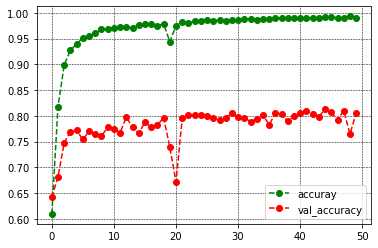

In [21]:
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['accuray','val_accuracy'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

In [22]:
y_pred=model.predict(X_test)
print(y_pred)
print(y_pred.shape)

[[1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.4089201e-29 1.0000000e+00 3.1111430e-31]
 [5.2067392e-08 2.2030257e-05 1.1462615e-01 2.9231617e-01 5.9303564e-01]
 ...
 [1.0000000e+00 3.6227391e-17 4.3753363e-21 2.2879974e-11 1.8912776e-23]
 [1.0000000e+00 1.1137114e-27 8.0804905e-34 7.5805866e-27 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 3.1971080e-30 5.3376535e-29]]
(3942, 5)


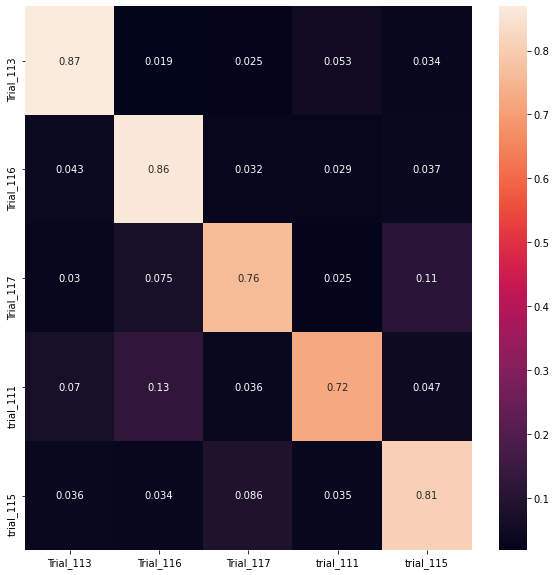

In [23]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encode.inverse_transform(y_pred)
    return y_pred






Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encode.classes_,yticklabels=encode.classes_)
plt.show()

In [24]:
print(X_train.shape)
print(X_test.shape)
print(X_train_encode.shape)
print(X_test_encode.shape)
print(y_train.shape)
print(y_test.shape)

(5913, 125, 1)
(3942, 125, 1)
(5913, 125)
(3942, 125)
(5913, 5)
(3942, 5)


In [25]:
dummy_ann = Model(inputs=model.input,outputs=model.layers[-3].output)
y_viz = dummy_ann.predict(X_train)
y_viz.shape

(5913, 750)

In [26]:
def T_SNE_plot(X_train,y_train,model,encode):
    
    dummy_ann = Model(inputs=model.input,outputs=model.layers[-2].output)
    y_viz = dummy_ann.predict(X_train_encode)
    
    from sklearn.manifold import TSNE

    X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

    tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

    tSNEdf['Fault']=inv_Transform_result(y_train)


    # Plot the PC-1 and PC-2
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
        data=tSNEdf,
        legend="full",
        alpha=0.3)
    plt.show()

C:\Users\abulf\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5913 samples in 0.005s...
[t-SNE] Computed neighbors for 5913 samples in 1.511s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5913
[t-SNE] Computed conditional probabilities for sample 2000 / 5913
[t-SNE] Computed conditional probabilities for sample 3000 / 5913
[t-SNE] Computed conditional probabilities for sample 4000 / 5913
[t-SNE] Computed conditional probabilities for sample 5000 / 5913
[t-SNE] Computed conditional probabilities for sample 5913 / 5913
[t-SNE] Mean sigma: 2.480739
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.650856
[t-SNE] KL divergence after 300 iterations: 1.656781


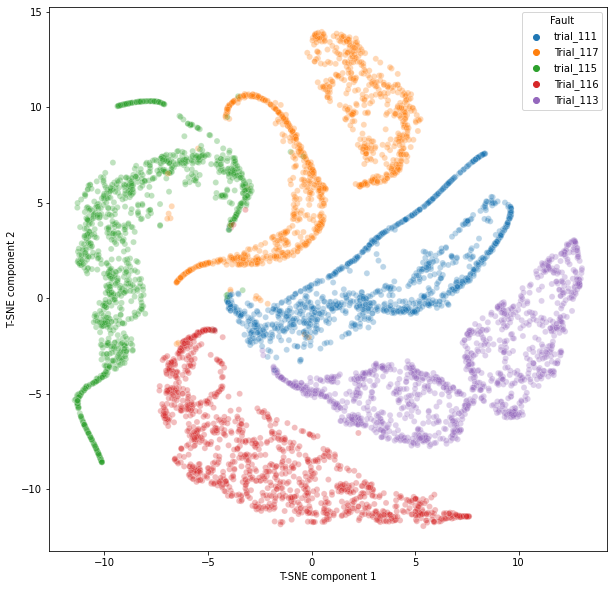

In [27]:
T_SNE_plot(X_train,y_train,model,encode)

In [28]:
y_test_class=np.argmax(y_test,axis=1)
y_pred_class=np.argmax(y_pred,axis=1)
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       795
           1       0.78      0.86      0.82       817
           2       0.81      0.76      0.78       773
           3       0.83      0.72      0.77       781
           4       0.78      0.81      0.79       776

    accuracy                           0.80      3942
   macro avg       0.81      0.80      0.80      3942
weighted avg       0.81      0.80      0.80      3942

